In [6]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

In [80]:
### common parameters
agnetsCount = 500
rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.01), np.arange(0.1, 0.31, 0.1)
])
distanceDs = np.concatenate([
    np.arange(0.1, 1.1, 0.1)
])

class1, class2 = (
    np.concatenate([np.ones(500), np.zeros(500)]).astype(bool), 
    np.concatenate([np.zeros(500), np.ones(500)]).astype(bool)
)
speedV = 3
dt = 0.01

targetPath = "lastStateRing_10.h5"  # lastStateAfter  # lastStateRing  # lastState

totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")

modelNums = totalPositionX.shape[0] // agnetsCount

totalPositionX = totalPositionX.values.reshape(modelNums, agnetsCount, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(modelNums, agnetsCount)
totalPointTheta = totalPointTheta.values.reshape(modelNums, agnetsCount)

idx = 0
positionX = dict()
phaseTheta = dict()
pointTheta = dict()

np.random.seed(10)
omegaTheta = np.concatenate([
    np.random.uniform(1, 3, size=500),
    np.random.uniform(-3, -1, size=500)
])

for l, d0 in product(rangeLambdas, distanceDs):
    
    positionX[f"{l:.3f}_{d0:.2f}"] = totalPositionX[idx]
    phaseTheta[f"{l:.3f}_{d0:.2f}"] = totalPhaseTheta[idx]
    pointTheta[f"{l:.3f}_{d0:.2f}"] = totalPointTheta[idx]

    idx += 1

In [81]:
maps1 = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)
for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    phaseAggOp = StateAnalysis._clac_phase_sync_op(lastPhaseTheta)
    maps1.loc[l, d0] = phaseAggOp
maps1.index = np.round(maps1.index, 4)
maps1.columns = np.round(maps1.columns, 4)

maps2 = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)
for l, d0 in product(rangeLambdas, distanceDs):
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)
    classes = StateAnalysis._calc_classes(
        centers, 0.3, 
        StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
    )
    counts = 0
    sumR = 0
    for classOcsis in classes:
        if len(classOcsis) <= 5:
            continue
        sumR += StateAnalysis._clac_phase_sync_op(lastPhaseTheta[classOcsis])
        counts += 1
    
    maps2.loc[l, d0] = sumR / counts
maps2.index = np.round(maps2.index, 4)
maps2.columns = np.round(maps2.columns, 4)

maps3 = pd.read_csv("SingleDistributeClusterDeltaOmega2.csv", index_col=0)  # clusterDeltaOmega2, deltaOmega1
maps3.index = maps3.index.astype(float)
maps3.columns = maps3.columns.astype(float)

In [84]:
maps = pd.read_csv("SingleDistributeClusterDeltaOmega2.csv", index_col=0)
maps.columns = maps.columns.astype(np.float64)

def lambda_c1(d0):
    rs = 3
    N = 500 / 4
    rho = N / (np.pi * (3**2 - 1**2))
    deltaOmega = 2 / N
    beta = 2 * np.arccos(1 - d0 ** 2 / (2 * rs ** 2))
    alpha = np.pi - beta / 2
    Si = d0**2 * alpha / 2 + rs**2 * beta / 2 - rs * d0 * np.sin(alpha / 2)
    sigmaA = Si * rho
    return deltaOmega / sigmaA

def lambda_c2(d0):
    rs = 1
    deltaOmega = 2
    beta = 2 * np.arccos(1 - d0 ** 2 / (2 * rs ** 2))
    alpha = np.pi - beta / 2
    N = 250
    return (
        np.pi * rs ** 2 * deltaOmega
        / (N - 1)
        / (alpha * d0**2 / 2 + beta * rs**2 / 2 - rs * d0 * np.sin(alpha / 2))
    )

def lambda_c3(d0):
    L = 5
    deltaOmega = 2
    N = 500
    return (
        deltaOmega
        / (N * np.pi * d0 ** 2 / L ** 2)
    )

funcIdxs = dict()
for func in [lambda_c1, lambda_c2, lambda_c3]:
    funcIdxs[func] = []
    for d0 in maps.columns:
        l = func(d0)
        idx = 0
        upper = maps.index[maps.index > l].min()
        if np.isnan(upper):
            upper = maps.index.max()
        idx = idx + np.where(maps.index == upper)[0][0]
        lower = maps.index[maps.index < l].max()
        if np.isnan(lower):
            lower = maps.index.min()
        idx = idx + np.where(maps.index == lower)[0][0]
        funcIdxs[func].append(idx / 2)

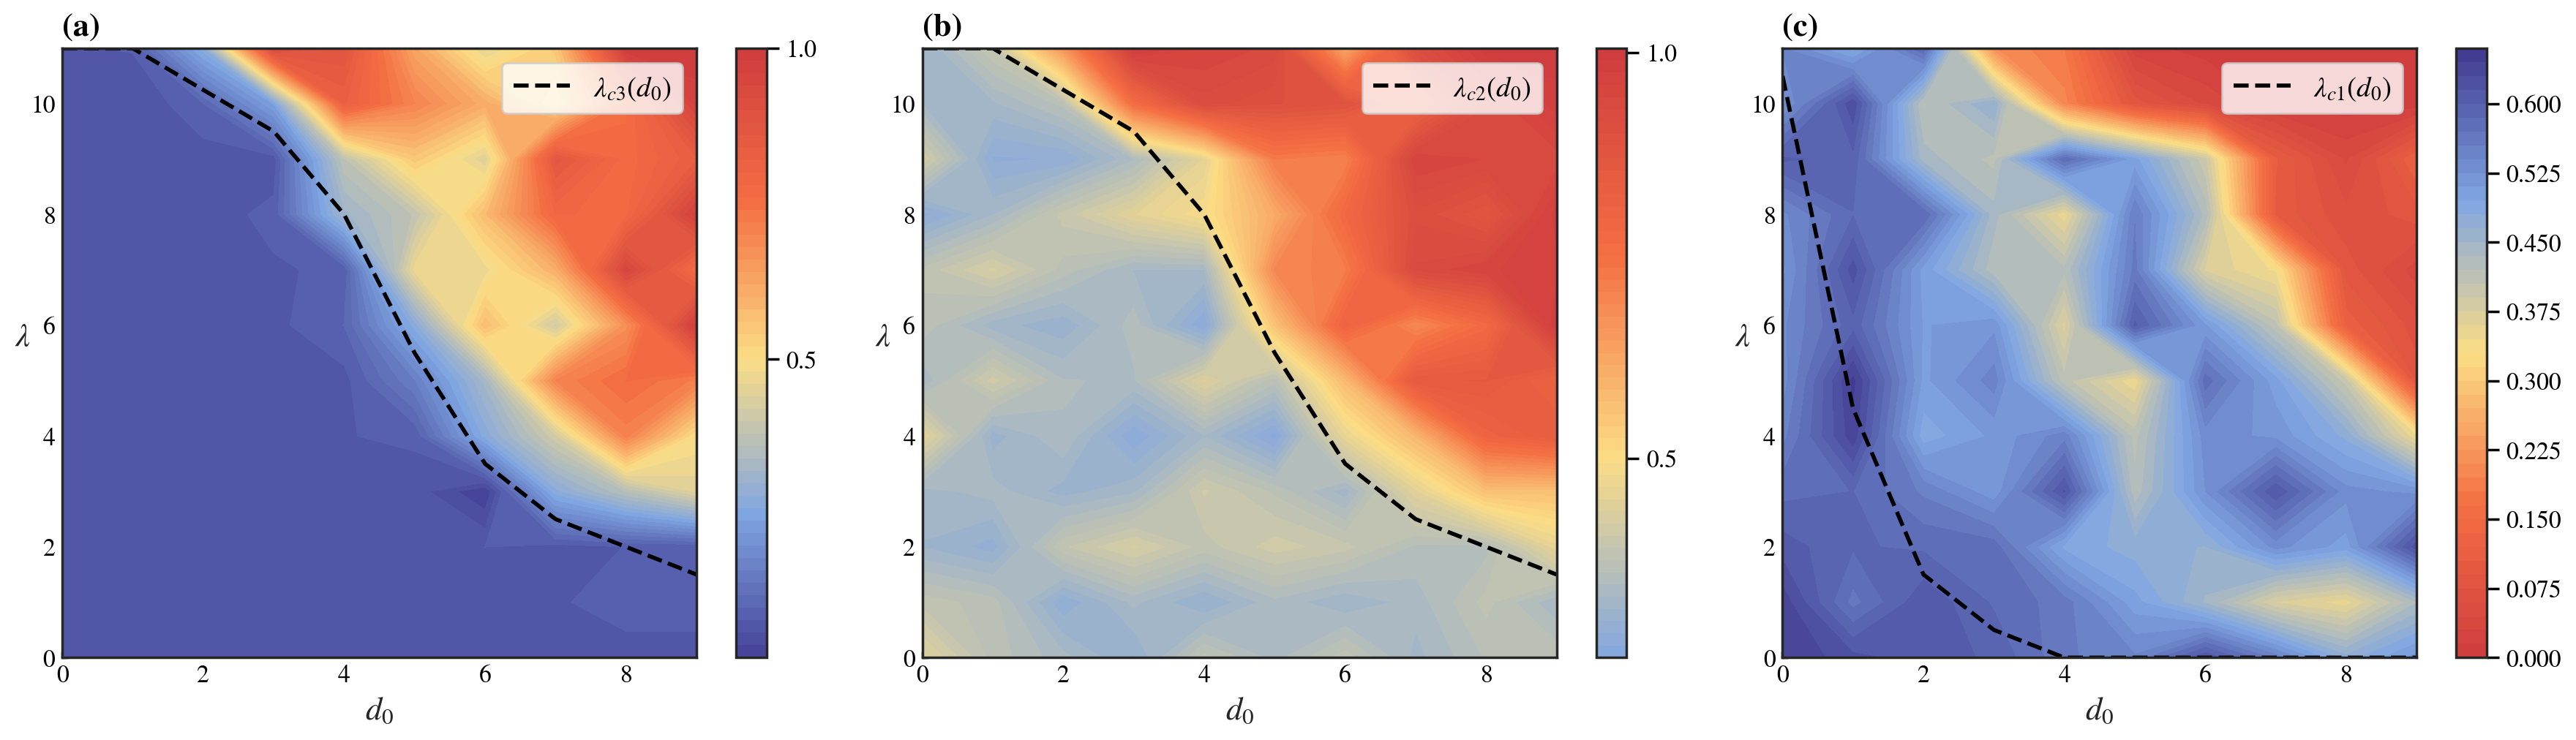

In [85]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5.3))
colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

line2 = pd.Series(funcIdxs[lambda_c2]).rolling(2, center=True, min_periods=1).mean()
line3 = pd.Series(funcIdxs[lambda_c3]).rolling(2, center=True, min_periods=1).mean()

level = 50
# 不显示轮廓线
cf1 = ax[0].contourf(
    maps1, levels=level, vmin=0, vmax=1,
    cmap=cmap,
)
cbar1 = plt.colorbar(cf1, ax=ax[0], ticks=[0, 0.5, 1])
ax[0].plot(np.arange(maps.shape[1]), line2, label=r"$\lambda_{c3}(d_0)$",
           linestyle="--", color="black", lw=2, zorder=2)
legend = ax[0].legend(facecolor="white", fontsize=14)

# legend.set_marker('s')

cf2 = ax[1].contourf(
    maps2, levels=level, vmin=0, vmax=1,
    cmap=cmap,
)
cbar2 = plt.colorbar(cf2, ax=ax[1], ticks=[np.min(maps2.values)-0.015, 0.5, 1])
cbar2.ax.set_yticklabels(['0.0', '0.5', '1.0'])
ax[1].plot(np.arange(maps.shape[1]), line2, label=r"$\lambda_{c2}(d_0)$",
           linestyle="--", color="black", lw=2, zorder=2)
legend = ax[1].legend(fontsize=14, facecolor="white", labelcolor="black")

cf3 = ax[2].contourf(
    maps3, levels=level, 
    cmap=cmap_r,
)
cbar3 = plt.colorbar(cf3, ax=ax[2])
ax[2].plot(np.arange(maps.shape[1]), funcIdxs[lambda_c1], label=r"$\lambda_{c1}(d_0)$",
           linestyle="--", color="black", lw=2, zorder = 2)
legend = ax[2].legend(fontsize=14, facecolor="white", labelcolor="black")

xIdxs = np.arange(len(distanceDs), step=5)
xIdxs = np.insert(xIdxs, -1, 18)
yIdxs = np.concatenate([np.arange(19, step=6), 18 + np.arange(18, step=6)[1:], [35]])
idx = np.where(rangeLambdas == 0.1)[0][0]
yIdxs = np.insert(yIdxs, 4, idx)

for i in range(3):
    ax[i].tick_params(direction='in', length=3)
    # ax[i].set_xticklabels(ax[i].get_xticks(), fontsize=14)
    # ax[i].set_yticklabels(ax[i].get_yticks(), fontsize=14)
    # ax[i].set_xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
    # ax[i].set_yticks(yIdxs, np.round(rangeLambdas, 2)[yIdxs])
    ax[i].set_xlabel(r"$d_0$", fontsize=16)
    ax[i].set_ylabel(r"$\lambda$", rotation=0, fontsize=16)
    ax[i].set_title(f"({chr(97 + i)})", loc="left", fontweight='bold', fontsize=16)

plt.tight_layout()
# plt.savefig("./PJT_C_Fig/orderParam.png", bbox_inches="tight", dpi=300)

In [32]:
pd.Series(funcIdxs[lambda_c2]).rolling(3, center=True, min_periods=1).mean()

0    11.000000
1    10.500000
2    10.000000
3     8.500000
4     6.833333
5     4.500000
6     3.166667
7     2.166667
8     1.833333
9     1.500000
dtype: float64